<a href="https://colab.research.google.com/github/mickvanhulst/twitter_bitcoin_analysis/blob/master/models/CNN_btc_kfold_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

* Autostop <-- DONE.
* Extend K-Fold. <- DONE
* Make sure to save results <-- DONE
* Add results. <-- retrieve results from npy dict --> https://stackoverflow.com/questions/30811918/saving-dictionary-of-numpy-arrays/45661259 <- DONE
* ADD MILESTONE 9 + 10 to BrightSpace.
* Visualize network https://github.com/szagoruyko/pytorchviz
* Apply styling, see brightspace.
* Apply requirements for literature section.
* Clean up code so that it can be delivered <-- just deliver K-Fold code + preprocessing stuff.
* https://cseweb.ucsd.edu/classes/fa17/cse291-b/reading/p152-donkers.pdf <-- go through this paper to check for missing information that I need to add.

Experimental setup:
----
* TFIDF
* TFIDF_w_user_data
* TFIDF_w_btc_MD
* TFIDF_w_all
* REPEAT FOR COUNT AND BINARY.
----
* P_TFIDF
* P_TFIDF_w_user_data
* P_TFIDF_w_btc_MD
* P_TFIDF_w_all
* REPEAT FOR COUNT AND BINARY.
----
* Custom features
* w_user_data
* w_btc_MD
* w_all


Probably best to do a table per model.

20*3 tests (three batch sizes) in total.

Table columns: model, batch_size (32, 64, 128), MAP (TR/VAL), MAP test, LR MAP Test, avg MAP Test.

Perhaps something like, scores in order of batch_size 32, 64, 128, so then I can do (0.48, 0.59, 0.6). 

# Install PyTorch

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

!pip install git+git://github.com/mickvanhulst/livelossplot.git --upgrade

tcmalloc: large alloc 1073750016 bytes == 0x5c176000 @  0x7f9a10fe12a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
True
  Cloning git://github.com/mickvanhulst/livelossplot.git to /tmp/pip-req-build-3ac2oh1k
  Running setup.py bdist_wheel for livelossplot ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-_yna9y3g/wheels/73/e2/09/79ee9f5b0be18dc9c6ee17f0dc181708c1cf9513c70053ca92
Successfully built livelossplot


# Load packages

In [0]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as utils

import matplotlib
import matplotlib.pyplot as plt

from google.colab import drive

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import os
import re

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load matrices

In [0]:
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
     
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    
    amazing <3 RegExp
    """
    l.sort(key=alphanum_key)
    return l

In [0]:
model_type = ['keywords_tfidf_p', 'keywords_tfidf', 'custom_features'][2]
mode = ['count', 'binary'][0]
INPUT_SIZE_CNN = 25 if model_type == 'keywords_clusters' else 126 if 'custom' in model_type else 250
train, test = None, None

In [0]:
train_classes, train_user_data, train_matrices, train_dates, train_btc_meta_data, train_classes_t = None, None, None, None, None, None
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/train/'.format(model_type, mode)
files = os.listdir(base_str)
for train_file in sort_nicely(files):
    if 'btc' in train_file:
        temp = np.load(base_str + train_file)
        if train_btc_meta_data is None:
            train_btc_meta_data = temp
        else:
            train_btc_meta_data = np.concatenate((train_btc_meta_data, temp), axis=0)
    elif 'tc_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_classes_t is None:
            train_classes_t = temp
        else:
            train_classes_t = np.concatenate((train_classes_t, temp), axis=0)
    elif 'c_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_classes is None:
            train_classes = temp
        else:
            train_classes = np.concatenate((train_classes, temp), axis=0)
    elif 'md_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_user_data is None:
            train_user_data = temp
        else:
            train_user_data = np.vstack((train_user_data, temp))
    elif 'dp_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_matrices is None:
            train_matrices = temp
        else:
            train_matrices = np.vstack((train_matrices, temp))
    elif 'dt_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_dates is None:
            train_dates = temp
        else:
            train_dates = np.concatenate((train_dates, temp), axis=0)

print('Train shapes: ', train_classes_t.shape, train_classes.shape, train_user_data.shape, 
      train_matrices.shape, train_dates.shape, train_btc_meta_data.shape)

Train shapes:  (127177,) (127177,) (127177, 8) (127177, 126, 7) (127177,) (127177, 7, 7)


In [0]:
test_classes, test_user_data, test_matrices, test_dates, test_btc_meta_data, test_classes_t = None, None, None, None, None, None
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/test/'.format(model_type, mode)

for test_file in sort_nicely(os.listdir(base_str)):
    if 'btc' in test_file:
        temp = np.load(base_str + test_file)
        if test_btc_meta_data is None:
            test_btc_meta_data = temp
        else:
            test_btc_meta_data = np.concatenate((test_btc_meta_data, temp), axis=0)
    elif 'tc_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_classes_t is None:
            test_classes_t = temp
        else:
            test_classes_t = np.concatenate((test_classes_t, temp), axis=0)
    elif 'c_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_classes is None:
            test_classes = temp
        else:
            test_classes = np.concatenate((test_classes, temp), axis=0)
    elif 'md_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_user_data is None:
            test_user_data = temp
        else:
            test_user_data = np.vstack((test_user_data, temp))
    elif 'dp_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_matrices is None:
            test_matrices = temp
        else:
            test_matrices = np.vstack((test_matrices, temp))
    elif 'dt_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_dates is None:
            test_dates = temp
        else:
            test_dates = np.concatenate((test_dates, temp), axis=0)
            
print('Test shapes: ', test_classes_t.shape, test_classes.shape, test_user_data.shape, 
      test_matrices.shape, test_dates.shape, test_btc_meta_data.shape)

Test shapes:  (35805,) (35805,) (35805, 8) (35805, 126, 7) (35805,) (35805, 7, 7)


In [0]:
# test_btc_meta_data = test_btc_meta_data[:,3:, :]
# train_btc_meta_data = train_btc_meta_data[:,3:, :]
# test_btc_meta_data.shape

(21853, 5, 7)

## Re-assign userIds and normalize data

In [0]:
# Re-assign tokens for userIds as this makes normalization easier (no precision errors).
unique_users = np.unique(np.concatenate((np.unique(train_user_data[:,-1]), np.unique(test_user_data[:,-1]))))
user_ids = {}
for i, v in enumerate(unique_users):
    user_ids[v] = (i+1)

for i, v in enumerate(train_user_data):
    train_user_data[i,-1] = user_ids[v[-1]]
    
for i, v in enumerate(test_user_data):
    test_user_data[i,-1] = user_ids[v[-1]]

In [0]:
test_user_data[0,-1]

4169.0

In [0]:
scaler = StandardScaler()
scaler.fit(train_user_data)
train_user_data = scaler.transform(train_user_data)
test_user_data = scaler.transform(test_user_data)

In [0]:
scalers = {}
for i in range(train_btc_meta_data.shape[1]):
    scalers[i] = StandardScaler()
    train_btc_meta_data[:, i, :] = scalers[i].fit_transform(train_btc_meta_data[:, i, :]) 

for i in range(test_btc_meta_data.shape[1]):
    test_btc_meta_data[:, i, :] = scalers[i].transform(test_btc_meta_data[:, i, :]) 

In [0]:
scalers = {}
for i in range(train_matrices.shape[1]):
    scalers[i] = StandardScaler()
    train_matrices[:, i, :] = scalers[i].fit_transform(train_matrices[:, i, :]) 

for i in range(test_matrices.shape[1]):
    test_matrices[:, i, :] = scalers[i].transform(test_matrices[:, i, :]) 

## Small test to see if flattening matrix and predicting directly with LR would have worked (absolutely sucks xD)

In [0]:
from sklearn.linear_model import LogisticRegression
X_inter = train_matrices[:, :int(train_matrices.shape[1]), :]
X_train = X_inter.reshape(X_inter.shape[0], -1)

X_train = X_train[:, :int(X_train.shape[1]/4)]
y_train = train_classes
# train_matrices = None

# instantiate the model (using the default parameters)
logreg = LogisticRegression(C=0.4, verbose=2)

In [0]:
# fit the model with data
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=2, warm_start=False)

In [0]:
y_pred = logreg.predict_proba(X_train)


In [0]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

Text(0.5,257.44,'Predicted label')

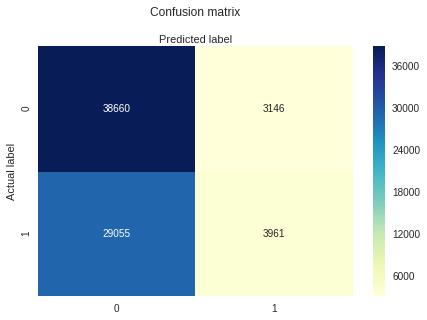

In [0]:
y_pred = logreg.predict(X_train)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
cnf_matrix

%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
from sklearn.metrics import average_precision_score
auc = average_precision_score(y_train, y_pred[:,1])
auc

0.4986545768362581

Average precision-recall score: 0.50


Text(0.5,1,'2-class Precision-Recall curve: AP=0.50')

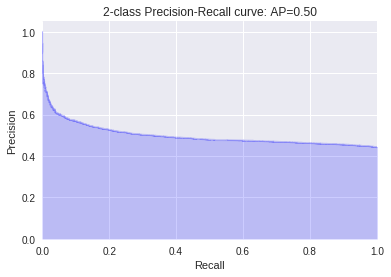

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

# auc, y, pred = test_model(test_loader, multi_class)
# losses, auc, y, pred = validate_model(val_loader, multi_class)
# losses, auc, y, pred = train_model(train_loader, multi_class)

# preds = [1 if x > 0.5 else 0 for x in pred]
# print(np.unique(preds, return_counts=True))
# print(np.unique(y, return_counts=True))
# print('The accuracy is: {}'.format(accuracy_score(y, preds)))
y, pred = y_train, y_pred[:,1]

average_precision = average_precision_score(y, pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y, pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

# Some analysis

## See which test users are not in train

In [0]:
indices = []
test_user_ids = np.unique(test_user_data[:,-1])
for i in range(len(train_user_data[:,-1])):
    if train_user_data[i,-1] not in test_user_ids:
        indices.append(i)
        
len(indices) / len(train_user_data[:,-1])

0.014578107676702548

In [0]:
train_matrices = np.delete(train_matrices, indices, axis=0)
train_classes_t = np.delete(train_classes_t, indices)
train_classes = np.delete(train_classes, indices)
train_user_data = np.delete(train_user_data, indices, axis=0)
train_btc_meta_data = np.delete(train_btc_meta_data, indices, axis=0)
train_dates = np.delete(train_dates, indices)
train_matrices.shape, train_classes_t.shape, train_user_data.shape

((125323, 126, 7), (125323,), (125323, 8))

## Check distribution of user-data to find important users.

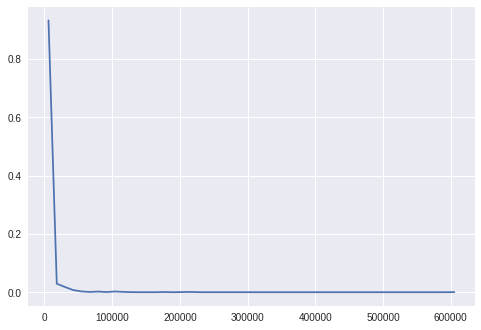

In [0]:
'''
TODO: find important users and filter entire dataset, including test set based on
those userIds. So every user that occurs in the test set, should also occur in 
training set. Else, it's removed.

Perhaps that should be my main criteria, not the amount of followers.
'''
# [['verified', 'followers_count', 'friends_count',
#                                'listed_count', 'favourites_count', 'statuses_count', 'unix_months',
#                                'twitter_user_id']]


# Histogram
heights,bins = np.histogram(copy_train_user_data[:, 1],bins=50)

# Normalize
heights = heights/float(sum(heights))
binMids=bins[:-1]+np.diff(bins)/2.
plt.plot(binMids,heights)

In [0]:
perc = 10
indices = np.argwhere(train_user_data[:, 1] <= np.percentile(train_user_data[:, 1], perc)).flatten()

train_matrices = np.delete(train_matrices, indices, axis=0)
train_classes_t = np.delete(train_classes_t, indices)
train_classes = np.delete(train_classes, indices)
train_user_data = np.delete(train_user_data, indices, axis=0)
train_btc_meta_data = np.delete(train_btc_meta_data, indices, axis=0)
train_dates = np.delete(train_dates, indices)
train_matrices.shape, train_classes_t.shape, train_user_data.shape

((112362, 250, 7), (112362,), (112362, 8))

In [0]:
np.unique(train_classes_t)

array([-1,  0,  1])

In [0]:
# indices = np.argwhere(test_user_data[:, 1] <= np.percentile(train_user_data[:, 1], perc)).flatten()

# test_matrices = np.delete(test_matrices, indices, axis=0)
# test_classes_t = np.delete(test_classes_t, indices)
# test_user_data = np.delete(test_user_data, indices, axis=0)
# test_btc_meta_data = np.delete(test_btc_meta_data, indices, axis=0)
# test_dates = np.delete(test_dates, indices)
# test_matrices.shape, test_classes_t.shape, test_user_data.shape,test_dates.shape

((15753, 500, 7), (15753,), (15753, 8), (15753,))

### Compare occurences users training versus test set

In [0]:
unique, counts = np.unique(train_user_data[:,-1], return_counts=True)
cnt_train = dict(zip(unique, counts))
unique, counts = np.unique(test_user_data[:,-1], return_counts=True)
cnt_test = dict(zip(unique, counts))

cnt_train, cnt_test

({-1.8449034827976734: 8,
  -1.8379357715339544: 1,
  -1.8191229511219125: 44,
  -1.8121552398581933: 1,
  -1.8079746130999619: 5,
  -1.8017036729626146: 7,
  -1.7877682504351762: 1,
  -1.7856779370560605: 19,
  -1.780103768045085: 32,
  -1.7794069969187132: 21,
  -1.7752263701604816: 17,
  -1.7612909476330432: 2,
  -1.7592006342539275: 1,
  -1.7515361518638364: 13,
  -1.7417813560946296: 1,
  -1.7403878138418856: 1,
  -1.7396910427155137: 4,
  -1.7257556201880755: 2,
  -1.7243620779353315: 47,
  -1.7111234265342652: 7,
  -1.6992783173859425: 63,
  -1.6902202927431076: 6,
  -1.686039665984876: 19,
  -1.685342894858504: 20,
  -1.6804654969739006: 13,
  -1.6790719547211568: 10,
  -1.677678412468413: 22,
  -1.6721042434574376: 1,
  -1.6707107012046938: 4,
  -1.6700139300783219: 3,
  -1.6651365321937184: 26,
  -1.6623494476882308: 1,
  -1.6616526765618589: 1,
  -1.660955905435487: 67,
  -1.660259134309115: 2,
  -1.6595623631827432: 19,
  -1.650504338539908: 62,
  -1.6498075674135362: 10,
 

## See which train users are not in test

In [0]:
indices = []
train_user_ids = np.unique(train_user_data[:,-1])
for i in range(len(test_user_data[:,-1])):
    if test_user_data[i,-1] not in train_user_ids:
        indices.append(i)
        
len(indices) / len(test_user_data[:,-1])

2.7929060187124703e-05

In [0]:
test_matrices = np.delete(test_matrices, indices, axis=0)
test_classes_t = np.delete(test_classes_t, indices)
test_classes = np.delete(test_classes, indices)
test_user_data = np.delete(test_user_data, indices, axis=0)
test_btc_meta_data = np.delete(test_btc_meta_data, indices, axis=0)
test_dates = np.delete(test_dates, indices)
test_matrices.shape, test_classes_t.shape, test_user_data.shape

((35804, 126, 7), (35804,), (35804, 8))

### Compare occurences users training versus test set

In [0]:
'''
NOTE: Amount of occurences is SUPER low, so I'm pretty sure we can't map any 
relevant information for a user.
'''

unique, counts = np.unique(train_user_data[:,-1], return_counts=True)
cnt_train = dict(zip(unique, counts))
unique, counts = np.unique(test_user_data[:,-1], return_counts=True)
cnt_test = dict(zip(unique, counts))

list_users_occ = [k for k,v in cnt_train.items() if v > 10]
list_users_occ, cnt_train

([8.39137366786943e-05,
  0.0009230511034656374,
  0.0013426197868591089,
  0.001678274733573886,
  0.0028530670470756064,
  0.0034404632038264665,
  0.0037761181505412437,
  0.004363514307292104,
  0.004699169254006881,
  0.005034824200721658,
  0.005118737937400353,
  0.00545439288411513,
  0.005873961567508601,
  0.005957875304187296,
  0.00604178904086599,
  0.0062096165142233786,
  0.006964840144331627,
  0.008223546194512042,
  0.009230511034656374,
  0.009314424771335067,
  0.009398338508013762,
  0.009817907191407233,
  0.01015356213812201,
  0.010405303348158094,
  0.010740958294872871,
  0.010824872031551564,
  0.01090878576823026,
  0.010992699504908953,
  0.011412268188302425,
  0.011496181924981119,
  0.012167491818410673,
  0.012587060501804146,
  0.01367793907862717,
  0.014181421498699337,
  0.014600990182092809,
  0.015188386338843668,
  0.015272300075522363,
  0.016279264915666693,
  0.016447092389024084,
  0.01653100612570278,
  0.01661491986238147,
  0.0169505748090

# Device config


In [17]:
# Device configuration
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# One-hot encoding

In [0]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories='auto')
enc.fit(train_classes_t.reshape(-1, 1))

# 3. Transform
train_classes_t = enc.transform(train_classes_t.reshape(-1, 1)).toarray()
test_classes_t = enc.transform(test_classes_t.reshape(-1, 1)).toarray()

## Check class imbalance

In [0]:
cnt_1, cnt_2, cnt_3 = 0, 0, 0
for i in test_classes_t:
    j = list(i)
    if j == [1, 0, 0]:
        cnt_1+=1
    elif j == [0, 1, 0]:
        cnt_2+=1
    elif j == [0, 0, 1]:
        cnt_3+=1
        
cnt_1/ len(test_classes_t), cnt_2/ len(test_classes_t), cnt_3 / len(test_classes_t)

(0.48407400343314894, 0.2944243117807871, 0.22150168478606397)

In [0]:
cnt_1, cnt_2, cnt_3 = 0, 0, 0
for i in train_classes_t:
    j = list(i)
    if j == [1, 0, 0]:
        cnt_1+=1
    elif j == [0, 1, 0]:
        cnt_2+=1
    elif j == [0, 0, 1]:
        cnt_3+=1
        
cnt_1/ len(train_classes_t), cnt_2/ len(train_classes_t), cnt_3 / len(train_classes_t)

(0.35532067270886325, 0.38490603314153066, 0.2597732941496061)

In [0]:
train_classes_t.shape, train_matrices.shape, test_classes_t.shape, test_matrices.shape, 

((80986, 3), (80986, 500, 7), (15729, 3), (15729, 500, 7))

# Model

In [0]:
# Hyper parameters
num_epochs = 25
multi_class = False
num_classes = 3 if multi_class else 1
batch_size = 128
learning_rate = 0.1
size_user_info = 8

tensor_1 = torch.from_numpy(train_matrices)
tensor_2 = torch.from_numpy(train_classes_t) if multi_class else torch.from_numpy(train_classes)
tensor_3 = torch.from_numpy(train_user_data.astype(float))
tensor_4 = torch.from_numpy(train_dates.astype(float))
tensor_5 = torch.from_numpy(train_btc_meta_data.astype(float))

full_dataset = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4, tensor_5)

tensor_1 = torch.from_numpy(test_matrices)
tensor_2 = torch.from_numpy(test_classes_t) if multi_class else torch.from_numpy(test_classes)
tensor_3 = torch.from_numpy(test_user_data.astype(float))
tensor_4 = torch.from_numpy(test_dates.astype(float))
tensor_5 = torch.from_numpy(test_btc_meta_data.astype(float))

test = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4, tensor_5)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size,
                                          drop_last=True,
                                          shuffle=False)

## Setup Model

In [0]:
# https://github.com/rodgzilla/machine_learning_pytorch_simple_cnn_1d_nlp/blob/master/notebooks/CNN%201D.ipynb
# class ConvNet(nn.Module):
#     def __init__(self, num_classes):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv1d(INPUT_SIZE_CNN, 256, kernel_size=5, stride=1, padding=2)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.conv2 = nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=1)
#         self.conv3 = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(5*64, 128)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.fc2 = nn.Linear(128, 32)
#         self.fc3 = nn.Linear(32 + size_user_info, num_classes) # +  size_user_info
#         self.out_act = nn.Sigmoid()

#     def forward(self, x, user_data, btc_meta_data):
#         #print(x.shape, btc_meta_data.shape)
#         #x = torch.cat((x, btc_meta_data), 0)
#         #print(x.shape)
#         x = x.view(batch_size, INPUT_SIZE_CNN, 7).float()
#         #print(x.shape)
#         x = F.relu(self.conv1(x))
#         #x = self.bn1(x)
#         #print(x.shape)
#         x = F.relu(self.conv2(x))
#         #print(x.shape)
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         #print(x.shape)
#         x = x.view(x.shape[0], -1)
#         #print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = self.bn2(x)
#         x = self.fc2(x)
#         x = torch.cat((x, user_data.float()), 1)
#         x = self.fc3(x)
#         if not multi_class:
#             x = self.out_act(x)
#         return x
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        # Todo: add batchnorm for all layers?
        self.conv1 = nn.Conv1d(7, 256, kernel_size=5, stride=1, padding=2) #+ 7
        self.bn1 = nn.BatchNorm1d(256)
        
        self.conv2 = nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.fc1 = nn.Linear(5*64, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.drop2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(32 + size_user_info, num_classes) # +  size_user_info
        self.bn7 = nn.BatchNorm1d(num_classes)
        self.drop3 = nn.Dropout(0.5)
        
        self.out_act = nn.Sigmoid()

    def forward(self, x, user_data, btc_meta_data):
        x = btc_meta_data#torch.cat((x, btc_meta_data), 1)
        x = x.view(batch_size, btc_meta_data.shape[1], 7).float() #+ btc_meta_data.shape[1]
        x = self.bn1(F.relu(self.conv1(x)))

        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = x.view(x.shape[0], -1)

        x = self.drop1(self.bn5(F.relu(self.fc1(x))))
        x = self.drop2(self.bn6(F.relu(self.fc2(x))))
        
        x = torch.cat((x, user_data.float()), 1)
        x = self.drop3(self.bn7(self.fc3(x)))
        
        if not multi_class:
            x = self.out_act(x)
        return x

model = ConvNet(num_classes).to(device)

#criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

263499


# Train and test final model

In [0]:
import numpy as np
import torch

class EarlyStopping:
    """
    Early stops the training if validation loss dosen't improve after a given patience.
    CREDITS GO TO: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/data/btc/models/{}/{}/{}_checkpoint.pt'.format(model_type, batch_size, np.round(map_score, 3)))
        self.val_loss_min = val_loss

In [0]:
# Init model
model = ConvNet(num_classes).to(device)

if multi_class:
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-2)#S

# Set train and validation data loaders.
len_train = int(len(full_dataset) * 0.8)
len_val = len(full_dataset) - len_train
len_train_temp = len_train

train, validation = torch.utils.data.dataset.random_split(full_dataset, [len_train, len_val])
# len_train = [x for x in range(0, len_train_temp)]
# len_val = [x for x in range(len_train_temp, len(full_dataset))]
# train = torch.utils.data.dataset.Subset(full_dataset, len_train)
# validation = torch.utils.data.dataset.Subset(full_dataset, len_val)


train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           drop_last=True,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=validation,
                                          batch_size=batch_size,
                                          drop_last=True,
                                          shuffle=True)

total_step = len(train_loader)

train_losses, train_aucs, val_losses, val_aucs = [], [], [], []

early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(num_epochs):
    train_loss, train_auc, _, _ = train_model(train_loader, multi_class)
    val_loss, val_auc, _, _ = validate_model(val_loader, multi_class)
    train_losses.append(train_loss)
    train_aucs.append(train_auc)
    val_losses.append(val_loss)
    val_aucs.append(val_aucs)
    print('At end of epoch, average (training) loss: {}, MAP: {} '.format(train_loss, train_auc))
    print('At end of epoch, average (validation) loss: {}, MAP: {} '.format(val_loss, val_auc))
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("EARLY STOPPAGE AFTER {} EPOCHS".format(epoch))
        break

map_score, y, pred = test_model(test_loader, multi_class)

# Save the model checkpoint
torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/data/btc/models/model_{}_{}_{}_{}_{}.ckpt'.format(
    num_epochs, batch_size, model_type, auc, time.time()))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [1/25], Step [1/783], Loss: 0.8925
Epoch [1/25], Step [262/783], Loss: 0.7990
Epoch [1/25], Step [523/783], Loss: 0.7745
Epoch [1/25], val MAP/acc: 0.4496794871794872, val loss: 15.205917358398438
At end of epoch, average (training) loss: 0.7581698298454285, MAP: 0.4510092415718665 
At end of epoch, average (validation) loss: 15.205917358398438, MAP: 0.4496794871794872 
Epoch [2/25], Step [1/783], Loss: 16.1901
Epoch [2/25], Step [262/783], Loss: 12.5590
Epoch [2/25], Step [523/783], Loss: 12.5059
Epoch [2/25], val MAP/acc: 0.449599358974359, val loss: 12.422890663146973
At end of epoch, average (training) loss: 12.515069007873535, MAP: 0.4523784655512405 
At end of epoch, average (validation) loss: 12.422890663146973, MAP: 0.449599358974359 
Validation loss decreased (inf --> 12.422891).  Saving model ...
Epoch [3/25], Step [1/783], Loss: 13.1679
Epoch [3/25], Step [262/783], Loss: 12.5195
Epoch [3/25], Step [523/783], Loss: 12.5327
Epoch [3/25], val MAP/acc: 0.44979967948717947

Test MAP: 0.4258512544802867
(array([0]), array([35712]))
(array([0, 1]), array([20504, 15208]))
The accuracy is: 0.5741487455197133
Average precision-recall score: 0.43


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.43')

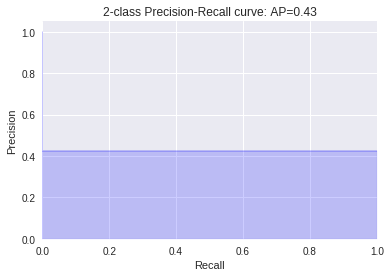

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

auc, y, pred = test_model(test_loader, multi_class)
#losses, auc, y, pred = validate_model(val_loader, multi_class)
#losses, auc, y, pred = train_model(train_loader, multi_class)

preds = [1 if x > 0.5 else 0 for x in pred]
print(np.unique(preds, return_counts=Tue))
print(np.unique(y, return_counts=True))
print('The accuracy is: {}'.format(accuracy_score(y, preds)))

average_precision = average_precision_score(y, pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y, pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

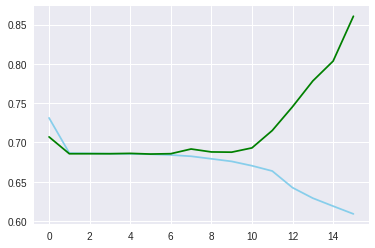

In [0]:
# Make plot.
plt.plot(train_losses, color='skyblue')
plt.plot(val_losses, color='green')
plt.show()

In [0]:
plt.plot(train_aucs, color='skyblue')
plt.plot(val_aucs, color='green')
plt.show()

In [0]:
auc, y, pred = test_model(test_loader, multi_class)

Test MAP: 0.40002634756017913


## (Optional) Load model

In [0]:
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc'
model = model.load_state_dict(torch.load('{}/model_{}_{}_{}.ckpt'.format(
    base_str, num_epochs, batch_size, 'cluster')))


NameError: ignored

## Methods

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

def validate_model(val_loader, multi_class):
    model.eval()
    with torch.no_grad():
        pred = []
        y = []
        losses = []
        for images, labels, user_data, dates, btc_meta_data in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            btc_meta_data = btc_meta_data.to(device)
            outputs = model(images, user_data, btc_meta_data)
            if multi_class:
                loss = criterion(outputs, torch.max(labels, 1)[1])
                pred.extend(torch.max(outputs, 1)[1].data.cpu().numpy())
                y.extend(torch.max(labels, 1)[1].data.cpu().numpy())
            else:
                loss = criterion(outputs, labels.float())
                pred.extend(outputs.data.cpu().numpy())
                y.extend(labels.data.cpu().numpy())
            losses.append(loss.data.cpu().numpy())
            
        losses = np.mean(losses)
      
        if multi_class:
            auc = accuracy_score(y, pred)
        else:
            auc = average_precision_score(y, pred)

        print('Epoch [{}/{}], val MAP/acc: {}, val loss: {}'
              .format(epoch + 1, num_epochs, auc, losses))
        return losses, auc, y, pred

def train_model(train_loader, multi_class):
    losses = []
    pred = []
    y = []
    for i, (images, labels, user_data, dates, btc_meta_data) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        btc_meta_data = btc_meta_data.to(device)
        outputs = model(images, user_data, btc_meta_data)
        
        if multi_class:
            loss = criterion(outputs, torch.max(labels, 1)[1])
            pred.extend(torch.max(outputs, 1)[1].data.cpu().numpy())
            y.extend(torch.max(labels, 1)[1].data.cpu().numpy())
        else:
            loss = criterion(outputs, labels.float())
            pred.extend(outputs.data.cpu().numpy())
            y.extend(labels.data.cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.cpu().numpy())
        
        if i % int(len(train_loader) / 3)  == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, np.mean(losses)))

    if multi_class:
        auc = accuracy_score(y, pred)
    else:
        auc = average_precision_score(y, pred)

    return np.mean(losses), auc, y, pred

def test_model(test_loader, multi_class):
    model.eval()
    with torch.no_grad():
        pred = []
        y = []
        for images, labels, user_data, dates, btc_meta_data in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            btc_meta_data = btc_meta_data.to(device)
            outputs = model(images, user_data, btc_meta_data)
            if multi_class:
                pred.extend(torch.max(outputs, 1)[1].data.cpu().numpy())
                y.extend(torch.max(labels, 1)[1].data.cpu().numpy())
            else:
                pred.extend(outputs.data.cpu().numpy())
                y.extend(labels.data.cpu().numpy())
            
      
        if multi_class:
            auc = accuracy_score(y, pred)
        else:
            auc = average_precision_score(y, pred)

        print('Test MAP: {}'.format(auc))
        return auc, y, pred

# K-Fold CV - SUPER MEGA DEATH LOOP.

## Methods

### Early stoppage class

In [0]:
class EarlyStopping:
    """
    Early stops the training if validation loss dosen't improve after a given patience.
    CREDITS GO TO: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
                            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        
    def __call__(self, val_loss, model):

        score = -val_loss
        
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        #torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/data/btc/models/{}/{}/{}_checkpoint.pt'.format(model_type, batch_size, np.round(map_score, 3)))
        self.val_loss_min = val_loss

### Aggregate test

In [0]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns


def conf_matrix(combination, batch_size, conf_matrix, score_type):    
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt='g')
    ax.xaxis.set_label_position("top")
#     plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/data/btc/result_conf_matrix/{}_{}_{}_{}_{}_{}'.format(combination[0], combination[1], int(combination[2]), int(combination[3]), batch_size, score_type))
    plt.close()

def mean_pred_test(combination, train_df, test_df):
#     for i in range(1, 99):
#         threshold = i / 100
#         cnt_MV = 0
#         cnt_max = 0
#         dates = train_df['date'].unique()
#         score = 0

#         for date in dates:
#             temp = train_df[train_df['date'] == date]
#             y_true = temp['true'].unique()[0]
#             MV = temp['pred_max'].value_counts().index[0]

#             max_out = temp['output'].mean()
#             max_all = 1 if max_out >= threshold else 0

#             if y_true == max_all:
#                 cnt_max += 1
#         new_score = cnt_max / len(dates)
#         if new_score > score:
#             best_thresh = threshold
#             score = new_score

#     cnt_max = 0
#     pairs = []
    dates = test_df['date'].unique()
    y_test = []
    y_pred = []
    for date in dates:
        temp = test_df[test_df['date'] == date]
        y_true = temp['true'].unique()[0]

        max_out = temp['output'].mean()
        #print(max_out)
        max_all = 1.0 if max_out > 0.5 else 0.0
        y_pred.append(max_all)
        y_test.append(y_true)
    #print(y_test, y_pred)
    #conf_matrix(combination, y_test, y_pred)
    return metrics.confusion_matrix(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)

def dataset_LR(train_df, test_df):
    # Create dataset first.
    train_users = train_df['user'].unique()
    test_users = test_df['user'].unique()

    users = np.concatenate((train_users, test_users))
    user_ids_lr = {}
    for i, v in enumerate(users):
        user_ids_lr[v] = i

    # Loop over dates, check if user has prediction
    X_train = None
    y_train = []
    cnt = 0
    for date in train_df['date'].unique():
        cnt += 1
        temp = train_df[train_df['date'] == date]
        arr = np.zeros(len(users))
        for row in temp.itertuples():
            usr = row[5]
            pred = row[2]
            lbl = row[4]
            arr[user_ids_lr[usr]] = pred
        y_train.append([lbl])
        if X_train is None:
            X_train = arr
        else:
            X_train = np.vstack((X_train, arr))
    
    y_train = np.array(y_train)  

    # Loop over dates, check if user has prediction
    X_test = None
    y_test = []

    for date in test_df['date'].unique():
        cnt += 1
        temp = test_df[test_df['date'] == date]
        arr = np.zeros(len(users))
        for row in temp.itertuples():
            usr = row[5]
            pred = row[2]
            lbl = row[4]
            try:
                arr[user_ids_lr[usr]] = pred
            except:
                #print('User {} not found'.format(usr))
                cnt_n += 1
        y_test.append([lbl])
        if X_test is None:
            X_test = arr
        else:
            X_test = np.vstack((X_test, arr))

    y_test = np.array(y_test)
    return X_train, y_train, X_test, y_test
    
    
def LR(combination, train_df, test_df):    
    X_train, y_train, X_test, y_test = dataset_LR(train_df, test_df)
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()

    # fit the model with data
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    y_pred_prob = logreg.predict_proba(X_test)[:,1]
    #print(y_pred_prob, y_test)
    #conf_matrix(combination, y_test, y_pred)
    return metrics.confusion_matrix(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)

def aggregate_evaluation_test(combination):
    ## Create datasets.
    train_lr = None
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        for images, labels, user_data, dates, btc_meta_data in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            btc_meta_data = btc_meta_data.to(device)
            outputs = model(images, user_data, btc_meta_data, batch_size, combination[2], combination[3])
            predicted = torch.max(outputs, 1)[1].data.cpu().numpy()

            if multi_class:
                labels = torch.max(labels, 1)[1].data.cpu().numpy()
                temp = np.dstack((labels, user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
                temp = np.hstack((outputs, temp))

            else:
                outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
                temp = np.dstack((outputs, labels, 
                                   user_data.data.cpu().numpy()[:,-1],
                                   dates.data.cpu().numpy(), predicted)).squeeze()
            if train_lr is None:
                train_lr = temp
            else:
                train_lr = np.concatenate((train_lr, temp), axis=0)
                
                
    test_lr = None
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        for images, labels, user_data, dates, btc_meta_data in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            btc_meta_data = btc_meta_data.to(device)
            outputs = model(images, user_data, btc_meta_data, batch_size, combination[2], combination[3])
            predicted = torch.max(outputs, 1)[1].data.cpu().numpy()

            if multi_class:
                labels = torch.max(labels, 1)[1].data.cpu().numpy()
                temp = np.dstack((labels, user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
                temp = np.hstack((outputs, temp))
            else:
                outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
                temp = np.dstack((outputs, labels, 
                                   user_data.data.cpu().numpy()[:,-1],
                                   dates.data.cpu().numpy(), predicted)).squeeze()

            if test_lr is None:
                test_lr = temp
            else:
                test_lr = np.concatenate((test_lr, temp), axis=0)
                
    train_df = pd.DataFrame({'output':train_lr[:,0],'true':train_lr[:,1], 
                                   'user':train_lr[:,2], 'date':train_lr[:,3], 'pred_max':train_lr[:,4]})
    test_df = pd.DataFrame({'output':test_lr[:,0],'true':test_lr[:,1], 
                                       'user':test_lr[:,2], 'date':test_lr[:,3], 'pred_max':test_lr[:,4]})
    
    mean_conf, mean_prec, mean_recall = mean_pred_test(combination, train_df, test_df)
    LR_conf, LR_prec, LR_recall = LR(combination, train_df, test_df)
    
    return LR_conf, LR_prec, LR_recall, mean_conf, mean_prec, mean_recall

### Load data

In [0]:
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
     
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    
    amazing <3 RegExp
    """
    l.sort(key=alphanum_key)
    return l

def load_matrices(combination):
    model_type = combination[0]#['keywords_tfidf_p', 'keywords_tfidf', 'custom_features'][2]
    mode = combination[1]#['count', 'binary'][0]
    INPUT_SIZE_CNN = 25 if model_type == 'keywords_clusters' else 126 if 'custom' in model_type else 500
    
    #train, test = None, None
    
    train_classes, train_user_data, train_matrices, train_dates, train_btc_meta_data, train_classes_t = None, None, None, None, None, None
    base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/train/'.format(model_type, mode)
    files = os.listdir(base_str)
    for train_file in sort_nicely(files):
        if 'btc' in train_file:
            temp = np.load(base_str + train_file)
            if train_btc_meta_data is None:
                train_btc_meta_data = temp
            else:
                train_btc_meta_data = np.concatenate((train_btc_meta_data, temp), axis=0)
        elif 'tc_up' in train_file:
            temp = np.load(base_str + train_file)
            if train_classes_t is None:
                train_classes_t = temp
            else:
                train_classes_t = np.concatenate((train_classes_t, temp), axis=0)
        elif 'c_up' in train_file:
            temp = np.load(base_str + train_file)
            if train_classes is None:
                train_classes = temp
            else:
                train_classes = np.concatenate((train_classes, temp), axis=0)
        elif 'md_up' in train_file:
            temp = np.load(base_str + train_file)
            if train_user_data is None:
                train_user_data = temp
            else:
                train_user_data = np.vstack((train_user_data, temp))
        elif 'dp_up' in train_file:
            temp = np.load(base_str + train_file)
            if train_matrices is None:
                train_matrices = temp
            else:
                train_matrices = np.vstack((train_matrices, temp))
        elif 'dt_up' in train_file:
            temp = np.load(base_str + train_file)
            if train_dates is None:
                train_dates = temp
            else:
                train_dates = np.concatenate((train_dates, temp), axis=0)

    test_classes, test_user_data, test_matrices, test_dates, test_btc_meta_data, test_classes_t = None, None, None, None, None, None
    base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/test/'.format(model_type, mode)

    for test_file in sort_nicely(os.listdir(base_str)):
        if 'btc' in test_file:
            temp = np.load(base_str + test_file)
            if test_btc_meta_data is None:
                test_btc_meta_data = temp
            else:
                test_btc_meta_data = np.concatenate((test_btc_meta_data, temp), axis=0)
        elif 'tc_up' in test_file:
            temp = np.load(base_str + test_file)
            if test_classes_t is None:
                test_classes_t = temp
            else:
                test_classes_t = np.concatenate((test_classes_t, temp), axis=0)
        elif 'c_up' in test_file:
            temp = np.load(base_str + test_file)
            if test_classes is None:
                test_classes = temp
            else:
                test_classes = np.concatenate((test_classes, temp), axis=0)
        elif 'md_up' in test_file:
            temp = np.load(base_str + test_file)
            if test_user_data is None:
                test_user_data = temp
            else:
                test_user_data = np.vstack((test_user_data, temp))
        elif 'dp_up' in test_file:
            temp = np.load(base_str + test_file)
            if test_matrices is None:
                test_matrices = temp
            else:
                test_matrices = np.vstack((test_matrices, temp))
        elif 'dt_up' in test_file:
            temp = np.load(base_str + test_file)
            if test_dates is None:
                test_dates = temp
            else:
                test_dates = np.concatenate((test_dates, temp), axis=0)
        
    # Normalize
    # Re-assign tokens for userIds as this makes normalization easier (no precision errors).
    unique_users = np.unique(np.concatenate((np.unique(train_user_data[:,-1]), np.unique(test_user_data[:,-1]))))
    user_ids = {}
    for i, v in enumerate(unique_users):
        user_ids[v] = (i+1)

    for i, v in enumerate(train_user_data):
        train_user_data[i,-1] = user_ids[v[-1]]

    for i, v in enumerate(test_user_data):
        test_user_data[i,-1] = user_ids[v[-1]]

    scaler = StandardScaler()
    scaler.fit(train_user_data)
    train_user_data = scaler.transform(train_user_data)
    test_user_data = scaler.transform(test_user_data)

    scalers = {}
    for i in range(train_btc_meta_data.shape[1]):
        scalers[i] = StandardScaler()
        train_btc_meta_data[:, i, :] = scalers[i].fit_transform(train_btc_meta_data[:, i, :]) 

    for i in range(test_btc_meta_data.shape[1]):
        test_btc_meta_data[:, i, :] = scalers[i].transform(test_btc_meta_data[:, i, :]) 

    scalers = {}
    for i in range(train_matrices.shape[1]):
        scalers[i] = StandardScaler()
        train_matrices[:, i, :] = scalers[i].fit_transform(train_matrices[:, i, :]) 

    for i in range(test_matrices.shape[1]):
        test_matrices[:, i, :] = scalers[i].transform(test_matrices[:, i, :]) 


    # Remove train/test users that are not in both sets.
    indices = []
    test_user_ids = np.unique(test_user_data[:,-1])
    for i in range(len(train_user_data[:,-1])):
        if train_user_data[i,-1] not in test_user_ids:
            indices.append(i)

    len(indices) / len(train_user_data[:,-1])

    train_matrices = np.delete(train_matrices, indices, axis=0)
    train_classes_t = np.delete(train_classes_t, indices)
    train_classes = np.delete(train_classes, indices)
    train_user_data = np.delete(train_user_data, indices, axis=0)
    train_btc_meta_data = np.delete(train_btc_meta_data, indices, axis=0)
    train_dates = np.delete(train_dates, indices)
    train_matrices.shape, train_classes_t.shape, train_user_data.shape

    indices = []
    train_user_ids = np.unique(train_user_data[:,-1])
    for i in range(len(test_user_data[:,-1])):
        if test_user_data[i,-1] not in train_user_ids:
            indices.append(i)

    len(indices) / len(test_user_data[:,-1])

    test_matrices = np.delete(test_matrices, indices, axis=0)
    test_classes_t = np.delete(test_classes_t, indices)
    test_classes = np.delete(test_classes, indices)
    test_user_data = np.delete(test_user_data, indices, axis=0)
    test_btc_meta_data = np.delete(test_btc_meta_data, indices, axis=0)
    test_dates = np.delete(test_dates, indices)
    test_matrices.shape, test_classes_t.shape, test_user_data.shape

    return train_classes, train_user_data, train_matrices, train_dates, train_btc_meta_data, train_classes_t, test_classes, test_user_data, test_matrices, test_dates, test_btc_meta_data, test_classes_t

In [0]:
# ['keywords_tfidf_p', 'count', True, False]
def load_data_kfold(combination):
    # Load matrices
    train_classes, train_user_data, train_matrices, train_dates, train_btc_meta_data, train_classes_t, test_classes, test_user_data, test_matrices, test_dates, test_btc_meta_data, test_classes_t = load_matrices(combination)
    # Preprocess data (remove test/train and normalize).
    
    # create tensors etc
    tensor_1 = torch.from_numpy(test_matrices)
    tensor_2 = torch.from_numpy(test_classes_t) if multi_class else torch.from_numpy(test_classes)
    tensor_3 = torch.from_numpy(test_user_data.astype(float))
    tensor_4 = torch.from_numpy(test_dates.astype(float))
    tensor_5 = torch.from_numpy(test_btc_meta_data.astype(float))

    test = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4, tensor_5)
    
    tensor_1 = torch.from_numpy(train_matrices)
    tensor_2 = torch.from_numpy(train_classes_t) if multi_class else torch.from_numpy(train_classes)
    tensor_3 = torch.from_numpy(train_user_data.astype(float))
    tensor_4 = torch.from_numpy(train_dates.astype(float))
    tensor_5 = torch.from_numpy(train_btc_meta_data.astype(float))

    full_dataset = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4, tensor_5)
    
    del train_classes, train_user_data, train_matrices, train_dates, train_btc_meta_data, train_classes_t, test_classes, test_user_data, test_matrices, test_dates, test_btc_meta_data, test_classes_t
    
    return full_dataset, test 

### Evaluate user specific data

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

def validate_model(val_loader, multi_class, batch_size, combination):
    model.eval()
    with torch.no_grad():
        pred = []
        y = []
        losses = []
        for images, labels, user_data, dates, btc_meta_data in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            btc_meta_data = btc_meta_data.to(device)
            outputs = model(images, user_data, btc_meta_data, batch_size, combination[2], combination[3])
            if multi_class:
                loss = criterion(outputs, torch.max(labels, 1)[1])
                pred.extend(torch.max(outputs, 1)[1].data.cpu().numpy())
                y.extend(torch.max(labels, 1)[1].data.cpu().numpy())
            else:
                loss = criterion(outputs, labels.float())
                #pred.extend(outputs.data.cpu().numpy())
                pred.extend([1 if x > 0.5 else 0 for x in outputs.data.cpu().numpy()])
                y.extend(labels.data.cpu().numpy())
            losses.append(loss.data.cpu().numpy())
            
        losses = np.mean(losses)
      
        if multi_class:
            auc = accuracy_score(y, pred)
        else:
            auc = [precision_score(y, pred), recall_score(y, pred)]#average_precision_score(y, pred)

        print('Epoch [{}/{}], val MAP/acc: {}, val loss: {}'
              .format(epoch + 1, num_epochs, auc, losses))
        
        return losses, auc, y, pred

def train_model(train_loader, multi_class, batch_size, combination):
    losses = []
    pred = []
    y = []
    for i, (images, labels, user_data, dates, btc_meta_data) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        btc_meta_data = btc_meta_data.to(device)
        outputs = model(images, user_data, btc_meta_data, batch_size, combination[2], combination[3])
        
        if multi_class:
            loss = criterion(outputs, torch.max(labels, 1)[1])
            pred.extend(torch.max(outputs, 1)[1].data.cpu().numpy())
            y.extend(torch.max(labels, 1)[1].data.cpu().numpy())
        else:
            loss = criterion(outputs, labels.float())
            #pred.extend(outputs.data.cpu().numpy())
            pred.extend([1 if x > 0.5 else 0 for x in outputs.data.cpu().numpy()])
            y.extend(labels.data.cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.cpu().numpy())
        
        if i % int(len(train_loader) / 3)  == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, np.mean(losses)))

    if multi_class:
        auc = accuracy_score(y, pred)
    else:
        auc = [precision_score(y, pred), recall_score(y, pred)]#average_precision_score(y, pred)

    return np.mean(losses), auc, y, pred

def test_model(test_loader, multi_class, batch_size, combination):
    model.eval()
    with torch.no_grad():
        pred = []
        y = []
        for images, labels, user_data, dates, btc_meta_data in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            btc_meta_data = btc_meta_data.to(device)
            outputs = model(images, user_data, btc_meta_data, batch_size, combination[2], combination[3])
            if multi_class:
                pred.extend(torch.max(outputs, 1)[1].data.cpu().numpy())
                y.extend(torch.max(labels, 1)[1].data.cpu().numpy())
            else:
                #pred.extend(outputs.data.cpu().numpy())
                pred.extend([1 if x > 0.5 else 0 for x in outputs.data.cpu().numpy()])
                y.extend(labels.data.cpu().numpy())   
      
        if multi_class:
            auc = accuracy_score(y, pred)
        else:
            auc = [precision_score(y, pred), recall_score(y, pred)]#average_precision_score(y, pred)

        print('Test score: {}'.format(auc))
        return auc, y, pred

### Model

In [0]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        # Todo: add batchnorm for all layers?
        self.conv1 = nn.Conv1d(INPUT_SIZE_CNN, 256, kernel_size=5, stride=1, padding=2) #+ 7
        self.bn1 = nn.BatchNorm1d(256)
        
        self.conv2 = nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.fc1 = nn.Linear(5*64, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.drop2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(FCN_INPUT_SIZE, num_classes) # +  size_user_info
        self.bn7 = nn.BatchNorm1d(num_classes)
        self.drop3 = nn.Dropout(0.5)
        
        self.out_act = nn.Sigmoid()

    def forward(self, x, user_data, btc_meta_data, batch_size, use_btc, use_user):
        if use_btc:
            x = torch.cat((x, btc_meta_data), 1)
        x = x.view(batch_size, INPUT_SIZE_CNN, 7).float() #+ btc_meta_data.shape[1]
        
        x = self.bn1(F.relu(self.conv1(x)))

        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = x.view(x.shape[0], -1)

        x = self.drop1(self.bn5(F.relu(self.fc1(x))))
        x = self.drop2(self.bn6(F.relu(self.fc2(x))))
        
        if use_user:
            x = torch.cat((x, user_data.float()), 1)
        x = self.drop3(self.bn7(self.fc3(x)))
        
        if not multi_class:
            x = self.out_act(x)
        return x

## LOOPIE

In [0]:
# Hyper parameters
num_epochs = 35
batch_sizes = [32, 64, 128, 256, 512]
n_folds = 5
multi_class = False
num_classes = 1
size_user_info = 8
size_btc_md = 6
patience_early_stopping = 5
patience_reduce_lr = 2
learning_rate = 0.001


# Add combinations, make sure custom_features has 'count' due to mapping structure.
# 20 tests in total, 8 each for TFIDF/TFIDF-P, 4 for custom features.
# model_type = ['keywords_tfidf_p', 'keywords_tfidf', 'custom_features'][2]
# Booleans being the usage of btc meta-data and user meta-data or not.
combinations = [#['custom_features', 'count', False, False],
               #['custom_features', 'count', True, False],
               #['custom_features', 'count', False, True],
               #['custom_features', 'count', True, True],
                
               ['keywords_tfidf', 'binary', False, False],
               #['keywords_tfidf', 'binary', True, False],
               ['keywords_tfidf', 'binary', False, True],
               #['keywords_tfidf', 'binary', True, True],
               
               ['keywords_tfidf', 'count', False, False],
               #['keywords_tfidf', 'count', True, False],
               ['keywords_tfidf', 'count', False, True],
               #['keywords_tfidf', 'count', True, True],
               
               ['keywords_tfidf_p', 'binary', False, False],
               #['keywords_tfidf_p', 'binary', True, False],
               ['keywords_tfidf_p', 'binary', False, True],
               #['keywords_tfidf_p', 'binary', True, True],
               
               ['keywords_tfidf_p', 'count', False, False],
               #['keywords_tfidf_p', 'count', True, False],
               ['keywords_tfidf_p', 'count', False, True]]#,
               #['keywords_tfidf_p', 'count', True, True]]

for combination in combinations:
    print('-------------------------------')
    print('-------------------------------')
    print('STARTING NEW COMBINATION {}'.format(combination))
    print('-------------------------------')
    print('-------------------------------')
    
    if 'full_dataset' in globals():
        del full_dataset
        
    full_dataset, test_dataset = load_data_kfold(combination)
    kf = KFold(n_splits=n_folds, shuffle=True)
    results = {}

    for batch_size in batch_sizes:
        INPUT_SIZE_CNN = 126 if 'custom' in combination[0] else 500
        FCN_INPUT_SIZE = 32
        
        if combination[2] & combination[3]:
            INPUT_SIZE_CNN = INPUT_SIZE_CNN + size_btc_md
            FCN_INPUT_SIZE = FCN_INPUT_SIZE + size_user_info
        elif combination[2] & (not combination[3]):
            INPUT_SIZE_CNN = INPUT_SIZE_CNN + size_btc_md
        elif (not combination[2]) & combination[3]:
            FCN_INPUT_SIZE = FCN_INPUT_SIZE + size_user_info
        
        # Add learning rates that match the batch sizes.
        print('-------------------------------')
        print('Starting training for new batch size {}'.format(batch_size))
        print('-------------------------------')
        train_scores = []
        val_scores = []
        test_scores = []

        test_agg = []
        mean_conf_matrices = []
        LR_conf_matrices = []
        
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              drop_last=True,
                                              shuffle=False)
               
        for train_indexes, validation_indexes in kf.split(full_dataset):
            train = torch.utils.data.dataset.Subset(full_dataset, train_indexes)
            validation = torch.utils.data.dataset.Subset(full_dataset, validation_indexes)            
            
            # Add parameters for different model_combinations.
            model = ConvNet(num_classes).to(device)
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            early_stopping = EarlyStopping(patience=patience_early_stopping, 
                                           verbose=True)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', verbose=True, 
                                                       patience=patience_reduce_lr)

            # Set train and validation data loaders.
            train_loader = torch.utils.data.DataLoader(dataset=train,
                                                       batch_size=batch_size,
                                                       drop_last=True,
                                                       shuffle=True)
            val_loader = torch.utils.data.DataLoader(dataset=validation,
                                                      batch_size=batch_size,
                                                      drop_last=True,
                                                      shuffle=True)
            del train, validation
            
            total_step = len(train_loader)
            print('-------------------------------')
            print('Starting training for new fold')
            print('-------------------------------')
            for epoch in range(num_epochs):
                train_loss, train_score, _, _ = train_model(train_loader, multi_class,
                                                         batch_size, combination)
                val_loss, val_score, _, _ = validate_model(val_loader, multi_class, 
                                                         batch_size, combination)
                print('At end of epoch, average (training) loss: {}, score: {} '.format(train_loss, train_score))
                print('At end of epoch, average (validation) loss: {}, score: {} '.format(val_loss, val_score))
                early_stopping(val_loss, model)
                scheduler.step(val_loss)

                if early_stopping.early_stop:
                    print("EARLY STOPPAGE AFTER {} EPOCHS".format(epoch))
                    break
            test_score, y, pred = test_model(test_loader, multi_class, batch_size, combination)
            LR_conf, LR_prec, LR_recall, mean_conf, mean_prec, mean_recall = aggregate_evaluation_test(combination)
            
            print('Finished fold, scores: {}'.format([LR_prec, LR_recall, mean_prec, mean_recall]))
            
            train_scores.append(train_score)
            val_scores.append(val_score)
            test_scores.append(test_score)
            test_agg.append([LR_prec, LR_recall, mean_prec, mean_recall])
            mean_conf_matrices.append(mean_conf)
            LR_conf_matrices.append(LR_conf)

        # Take means and add to dict.
        results[batch_size] = [np.mean(train_scores, axis=0), np.mean(val_scores, axis=0), 
                               np.mean(test_scores, axis=0), np.mean(test_agg, axis=0)]

        # Save confusion matrix as mean of all folds.
        conf_matrix(combination, batch_size, np.mean(LR_conf_matrices, axis=0), 'LR')   
        conf_matrix(combination, batch_size, np.mean(mean_conf_matrices, axis=0), 'mean')
        
        print('-------------------------------')
        print('{}-fold validation has been executed, mean LR_prec, LR_recall, mean_prec, mean_recall: {}'.
              format(n_folds, np.mean(test_agg, axis=0)))
        
        
    # Save results for model type and all batch size combinations.
    np.save('/content/gdrive/My Drive/Colab Notebooks/data/btc/results/{}_{}_{}_{}'.format(combination[0], combination[1], int(combination[2]), int(combination[3])), np.array(results))
    print('Saved results')

-------------------------------
-------------------------------
STARTING NEW COMBINATION ['keywords_tfidf', 'binary', False, False]
-------------------------------
-------------------------------
-------------------------------
Starting training for new batch size 32
-------------------------------
-------------------------------
Starting training for new fold
-------------------------------
Epoch [1/35], Step [1/287], Loss: 0.6927


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [1/35], Step [96/287], Loss: 0.6922
Epoch [1/35], Step [191/287], Loss: 0.6919
Epoch [1/35], Step [286/287], Loss: 0.6912


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch [1/35], val MAP/acc: [0.0, 0.0], val loss: 0.6878663301467896
At end of epoch, average (training) loss: 0.6911812424659729, score: [0.5093457943925234, 0.02687376725838264] 
At end of epoch, average (validation) loss: 0.6878663301467896, score: [0.0, 0.0] 
Epoch [2/35], Step [1/287], Loss: 0.6892
Epoch [2/35], Step [96/287], Loss: 0.6879
Epoch [2/35], Step [191/287], Loss: 0.6884
Epoch [2/35], Step [286/287], Loss: 0.6878
Epoch [2/35], val MAP/acc: [0.7142857142857143, 0.0051813471502590676], val loss: 0.6842732429504395
At end of epoch, average (training) loss: 0.687824010848999, score: [0.35, 0.001726689689195856] 
At end of epoch, average (validation) loss: 0.6842732429504395, score: [0.7142857142857143, 0.0051813471502590676] 
Validation loss decreased (inf --> 0.684273).
Epoch [3/35], Step [1/287], Loss: 0.6920
Epoch [3/35], Step [96/287], Loss: 0.6789
Epoch [3/35], Step [191/287], Loss: 0.6813
Epoch [3/35], Step [286/287], Loss: 0.6827
Epoch [3/35], val MAP/acc: [1.0, 0.002

# Process final results

In [0]:
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/results/'
files = os.listdir(base_str)

results = {}
for file in files:
    results[file.strip('.npy')] = np.load(base_str + file)[()] 

In [0]:
# method, batch_size, train_map, val_map, test_map, test_lr, test_mean_pred.
columns = ['Experiment', 'Batch_size', 'type', 'btc_meta_data', 'user_meta_data', 'Train_MAP', 'Val_MAP', 'Test_MAP', 'MAP_Test_LR', 'MAP_test_mean']
final = []
for k in results.keys():
    for batch_size in [32, 64, 128, 256, 512]:
        k_replaced = k.replace('keywords_', '').replace('_count_', '').replace('_binary_', '')[:-3]

        t = 'Binary' if 'binary' in k else 'Count'
        b = 'Yes' if k[-3] == '1' else 'No'
        u = 'Yes' if k[-1] == '1' else 'No'
        
        temp = [k_replaced, batch_size, t, b, u]
        temp.extend(results[k][batch_size])
        # train_map, val_map, test_map, test_lr, test_mean_pred.
        final.append(temp)
        
# Booleans being the usage of btc meta-data and user meta-data or not.
final = pd.DataFrame.from_records(final, columns=columns)
final['Experiment'][final['Experiment'] == 'tfidf_p'] = 'Partial TF-IDF'
final['Experiment'][final['Experiment'] == 'tfidf'] = 'TF-IDF'
final = final[final['Experiment'] != 'custom_features']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
# Personally went through all combinations of experiments, types, btc meta data and user meta data to find the max scores.
a = final[(final['Experiment'] == 'Partial TF-IDF') & (final['type'] == 'Count') 
      & (final['btc_meta_data'] == 'Yes') & (final['user_meta_data'] == 'Yes')]

a.sort_values(['MAP_Test_LR', 'MAP_test_mean'], ascending=False)

,Experiment,Batch_size,type,btc_meta_data,user_meta_data,Train_MAP,Val_MAP,Test_MAP,MAP_Test_LR,MAP_test_mean
97,Partial TF-IDF,128,Count,Yes,Yes,0.452274,0.452363,0.427581,0.427886,0.428822
98,Partial TF-IDF,256,Count,Yes,Yes,0.451999,0.452126,0.425247,0.423729,0.431415
96,Partial TF-IDF,64,Count,Yes,Yes,0.452011,0.452011,0.427307,0.423729,0.415532
95,Partial TF-IDF,32,Count,Yes,Yes,0.452015,0.452081,0.427307,0.423729,0.408286
99,Partial TF-IDF,512,Count,Yes,Yes,0.452017,0.452002,0.421082,0.413793,0.404960


# Trading strategy

## Perform forward pass on training set to generate data for Logistic Regression and majority vote

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=full_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
train_lr = None

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    for images, labels, user_data, dates, btc_meta_data in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        btc_meta_data = btc_meta_data.to(device)
        outputs = model(images, user_data, btc_meta_data)
        predicted = torch.max(outputs, 1)[1].data.cpu().numpy()

        if multi_class:
            labels = torch.max(labels, 1)[1].data.cpu().numpy()
            temp = np.dstack((labels, user_data.data.cpu().numpy()[:,-1],
                           dates.data.cpu().numpy(), predicted)).squeeze()
            temp = np.hstack((outputs, temp))
            
        else:
            outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
            temp = np.dstack((outputs, labels, 
                               user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
        if train_lr is None:
            train_lr = temp
        else:
            train_lr = np.concatenate((train_lr, temp), axis=0)

In [0]:
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False, drop_last=True)
test_lr = None
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

with torch.no_grad():
    for images, labels, user_data, dates, btc_meta_data in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        btc_meta_data = btc_meta_data.to(device)
        outputs = model(images, user_data, btc_meta_data)
        predicted = torch.max(outputs, 1)[1].data.cpu().numpy()

        if multi_class:
            labels = torch.max(labels, 1)[1].data.cpu().numpy()
            temp = np.dstack((labels, user_data.data.cpu().numpy()[:,-1],
                           dates.data.cpu().numpy(), predicted)).squeeze()
            temp = np.hstack((outputs, temp))
        else:
            outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
            temp = np.dstack((outputs, labels, 
                               user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
        
        if test_lr is None:
            test_lr = temp
        else:
            test_lr = np.concatenate((test_lr, temp), axis=0)

## Create dataframe for LR and MV

In [0]:
import pandas as pd

if multi_class:
    train_df = pd.DataFrame({'output1':train_lr[:,0], 'output2':train_lr[:,1], 'output3':train_lr[:,2], 'true':train_lr[:,3], 
                                   'user':train_lr[:,4], 'date':train_lr[:,5], 'pred_max':train_lr[:,6]})
    test_df = pd.DataFrame({'output1':test_lr[:,0], 'output2':test_lr[:,1], 'output3':test_lr[:,2], 'true':test_lr[:,3], 
                                   'user':test_lr[:,4], 'date':test_lr[:,5], 'pred_max':test_lr[:,6]})
else:
    train_df = pd.DataFrame({'output':train_lr[:,0],'true':train_lr[:,1], 
                                       'user':train_lr[:,2], 'date':train_lr[:,3], 'pred_max':train_lr[:,4]})
    test_df = pd.DataFrame({'output':test_lr[:,0],'true':test_lr[:,1], 
                                       'user':test_lr[:,2], 'date':test_lr[:,3], 'pred_max':test_lr[:,4]})

In [0]:
# # Reset vars that we do not need anymore.
# train_classes, train_user_data, train_matrices, train_dates, train_btc_meta_data, train_classes_t = None, None, None, None, None, None
# test_classes, test_user_data, test_matrices, test_dates, test_btc_meta_data, test_classes_t = None, None, None, None, None, None

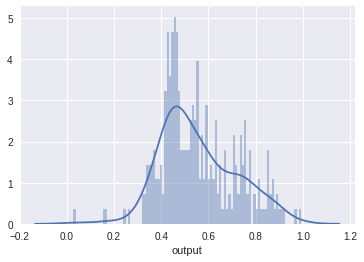

In [0]:
import seaborn 

seaborn.distplot(train_df['output'][train_df['date'] == 17548.0], bins=100)

## Thresholding training (only for binary classification)

In [0]:
data_MV = train_df[['date', 'output', 'true', 'pred_max']]
cnt_MV = 0
cnt_max = 0
pairs = []
dates = data_MV['date'].unique()
score = 0
for i in range(20, 80):
    threshold = i / 100
    cnt_MV = 0
    cnt_max = 0
    pairs = []
    for date in dates:
        temp = data_MV[data_MV['date'] == date]
        y_true = temp['true'].unique()[0]
        MV = temp['pred_max'].value_counts().index[0]

        max_all = temp['output'].mean()
        max_all = 1 if max_all >= threshold else 0

        if y_true == MV:
            cnt_MV += 1
        if y_true == max_all:
            cnt_max += 1
        else:
            pairs.append([max_all, y_true])
    new_score = cnt_max / len(dates)
    if new_score > score:
        best_thresh = threshold
        score = new_score
print('The best score was {} with threshold {}'.format(score, best_thresh))
print('Performing MV resulted in an acc of: {}'.format(cnt_MV / len(dates)))

The best score was 0.9921722113502935 with threshold 0.45
Performing MV resulted in an acc of: 0.5362035225048923


## Use best threshold for training set on test set to measure performance OR get mean per date for multi-class

correct 0.0 0.4212333805189865
correct 0.0 0.4249274776266525
correct 0.0 0.4045314504047116
correct 0.0 0.41927296124764685
correct 0.0 0.4276204223051895
correct 0.0 0.39052849712646764
correct 0.0 0.3985815997422369
correct 0.0 0.44702020708217144
correct 0.0 0.4319154014317533
wrong 0.0 0.45230078644903965
wrong 1.0 0.4081326952815233
correct 0.0 0.4235356306579404
correct 0.0 0.4303461099854732
wrong 1.0 0.44127278593493674
correct 0.0 0.4188311281602244
wrong 1.0 0.40785386330265555
correct 0.0 0.442664228676432
wrong 1.0 0.421235700153253
correct 0.0 0.4441434705083503
wrong 1.0 0.437079162125044
wrong 1.0 0.4329614365874132
correct 1.0 0.45418644773061
correct 0.0 0.43514654703470396
correct 1.0 0.45495849962628143
correct 0.0 0.4067084078009907
correct 0.0 0.42949879106975913
wrong 1.0 0.4441632110336641
correct 0.0 0.39626939624304336
correct 0.0 0.41901625769335865
correct 0.0 0.4315545199504654
wrong 1.0 0.4497457687765849
wrong 1.0 0.4471274614897247
correct 0.0 0.44627763

Text(0.5, 257.44, 'Predicted label')

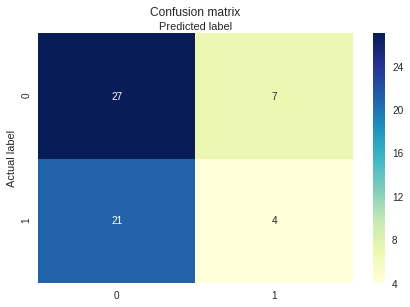

In [0]:
#data_MV = test_df[['date', 'output', 'true', 'pred_max']]
cnt_max = 0
pairs = []
dates = test_df['date'].unique()
y_test = []
y_pred = []
for date in dates:
    temp = test_df[test_df['date'] == date]
    y_true = temp['true'].unique()[0]
    
    MV = temp['pred_max'].value_counts().index[0]
    
    if multi_class:
        # Mean per column
        max_out = temp[['output1', 'output2', 'output3']].mean(axis=0).values
        max_all = np.argmax(max_out)
    else:
        max_out = temp['output'].mean()
        max_all = 1 if max_out > best_thresh else 0
    
    y_test.append(y_true)
    y_pred.append(max_all)
    if y_true == max_all:
        cnt_max += 1
        print('correct', y_true, max_out)
    else:
        print('wrong', y_true, max_out)
        pairs.append([max_all, y_true])

average_precision_score(y_test, y_pred_prob)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Create dataset LR multiclass

In [0]:
'''
We create a matrix with all zeroes and replace the user predictions if there
are any. If there's none, then we simply leave it at zero.

As we have three predictions per user/day, our matrix is 3x as wide as
in our binary case, ex:

[user_1_pred_c1, user_1_pred_c2, user_1_pred_c3, user_2_pred_c1, ..]
'''


# # Get all users
train_users = train_df['user'].unique()
test_users = test_df['user'].unique()
# print(train_users)
# print(test_users)
users = np.unique(np.concatenate((train_users, test_users)))
# # Assign users a unique id from 0 to n unique ids, 
# # create a dictionairy using training data and re-use during test time.
user_ids_lr = {}
cnt = 0
for i, v in enumerate(users):
    if cnt == 0:
        add = 0
    elif cnt == 1:
        add = 2
    else: 
        add = 3
    cnt += 1
    
    user_ids_lr[v] = i + add

# Loop over dates, check if user has prediction
X_train = None
y_train = []
cnt = 0
for date in train_df['date'].unique():
    cnt += 1
    temp = train_df[train_df['date'] == date]
    arr = np.zeros(len(users) * 3)
    for row in temp.itertuples():
        usr = row[7]
        pred1 = row[2]
        pred2 = row[3]
        pred3 = row[4]
        lbl = row[6]
        arr[user_ids_lr[usr]] = pred1
        arr[user_ids_lr[usr]+1] = pred2
        arr[user_ids_lr[usr]+2] = pred3
        
    y_train.append([lbl])

    if X_train is None:
        X_train = arr
    else:
        X_train = np.vstack((X_train, arr))

y_train = np.array(y_train)  

In [0]:
# Loop over dates, check if user has prediction
X_test = None
y_test = []
cnt = 0
for date in test_df['date'].unique():
    cnt += 1
    temp = test_df[test_df['date'] == date]
    arr = np.zeros(len(users) * 3)
    for row in temp.itertuples():
        usr = row[7]
        pred1 = row[2]
        pred2 = row[3]
        pred3 = row[4]
        lbl = row[6]
        arr[user_ids_lr[usr]] = pred1
        arr[user_ids_lr[usr]+1] = pred2
        arr[user_ids_lr[usr]+2] = pred3
        
    y_test.append([lbl])
    if X_test is None:
        X_test = arr
    else:
        X_test = np.vstack((X_test, arr))

y_test = np.array(y_test)  

## Create dataset LR binary class

In [0]:
'''
For logistic regression we'd the following input:
[user_pred_1, .... user_pred_n]

We create a matrix with all zeroes and replace the user predictions if there
are any. If there's none, then we simply leave it at zero.

So we get a matrix per day with predictions for all users.
'''


# # Get all users
train_users = train_df['user'].unique()
test_users = test_df['user'].unique()

users = np.concatenate((train_users, test_users))
user_ids_lr = {}
for i, v in enumerate(users):
    user_ids_lr[v] = i

# Loop over dates, check if user has prediction
X_train = None
y_train = []
cnt = 0
for date in train_df['date'].unique():
    cnt += 1
    temp = train_df[train_df['date'] == date]
    arr = np.zeros(len(users))
    for row in temp.itertuples():
        usr = row[5]
        pred = row[2]
        lbl = row[4]
        arr[user_ids_lr[usr]] = pred
    y_train.append([lbl])
    if X_train is None:
        X_train = arr
    else:
        X_train = np.vstack((X_train, arr))

y_train = np.array(y_train)  

In [0]:


# Loop over dates, check if user has prediction
X_test = None
y_test = []

for date in test_df['date'].unique():
    cnt += 1
    temp = test_df[test_df['date'] == date]
    arr = np.zeros(len(users))
    for row in temp.itertuples():
        usr = row[5]
        pred = row[2]
        lbl = row[4]
        try:
            arr[user_ids_lr[usr]] = pred
        except:
            #print('User {} not found'.format(usr))
            cnt_n += 1
    y_test.append([lbl])
    if X_test is None:
        X_test = arr
    else:
        X_test = np.vstack((X_test, arr))

y_test = np.array(y_test)

## Perform Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression


# instantiate the model (using the default parameters)
logreg = LogisticRegression(C=0.8)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_train)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
cnf_matrix

y_pred = logreg.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[25,  9],
       [18,  7]])

In [0]:
# Predict on test
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

print(average_precision_score(y_test, y_pred_prob))



0.45718148070639314


array([[25,  9],
       [18,  7]])

Text(0.5, 257.44, 'Predicted label')

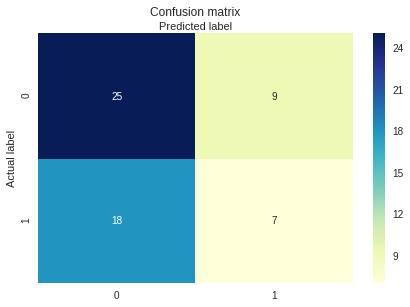

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



%matplotlib inline

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)



# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')